In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeoDataLoader  # PyGのDataLoader
from torch_geometric.nn import GATConv, global_mean_pool


# =========================================================
# 1. MNISTのデータをダウンロード＆前処理（8x8へリサイズ）
# =========================================================
transform = T.Compose([
    T.Resize((8, 8)),   # 28x28 -> 8x8 に縮小
    T.ToTensor()        # shape: (1,8,8), 値は [0,1]
])

# trainデータ・testデータ
mnist_train = torchvision.datasets.MNIST(root='.', train=True,  download=True, transform=transform)
mnist_test  = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=transform)

# 今回は学習用1000枚 & テスト用200枚だけ使う (計算負荷を下げるため)
train_subset = torch.utils.data.Subset(mnist_train, range(1000))
test_subset  = torch.utils.data.Subset(mnist_test, range(200))


# =========================================================
# 2. 「8x8画像」を「グラフ」(PyGのData)に変換する関数を用意
# =========================================================
def create_graph_from_image(img_tensor):
    """
    img_tensor: shape (1, H, W) = (1,8,8) のTorchテンソル (値:0~1)
    戻り値: PyGの Data(x, edge_index, y) で表されるグラフ
    """
    # 画素値をフラット化して (N,1) にする
    # N = H*W = 64
    c, h, w = img_tensor.shape
    assert c == 1  # モノクロ前提
    N = h * w
    
    x = img_tensor.view(N, 1)  # (64,1)
    
    # 上下左右で隣接関係を作る
    edge_list = []
    
    def node_index(row, col):
        return row * w + col
    
    for row in range(h):
        for col in range(w):
            idx = node_index(row, col)
            # 上
            if row > 0:
                edge_list.append([idx, node_index(row - 1, col)])
            # 下
            if row < h - 1:
                edge_list.append([idx, node_index(row + 1, col)])
            # 左
            if col > 0:
                edge_list.append([idx, node_index(row, col - 1)])
            # 右
            if col < w - 1:
                edge_list.append([idx, node_index(row, col + 1)])
    
    # (2, E) 形状のTensorに変換
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    # PyGのDataオブジェクトを返す (まだ y は設定しない)
    data = Data(x=x, edge_index=edge_index)
    return data


# =========================================================
# 3. PyTorch Dataset を拡張して、__getitem__()でグラフDataを返すクラス
# =========================================================
class MnistGraphDataset(Dataset):
    def __init__(self, subset):
        """
        subset: MNIST(またはそのSubset)などTorchVision Datasetを渡す想定
        """
        self.subset = subset

    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        img, label = self.subset[idx]  # img: (1,8,8), label: int
        g_data = create_graph_from_image(img)
        # ラベルを PyG data の y として格納 (shape: [1], long)
        g_data.y = torch.tensor([label], dtype=torch.long)
        return g_data


train_graph_dataset = MnistGraphDataset(train_subset)
test_graph_dataset  = MnistGraphDataset(test_subset)

# PyG の DataLoader を使用 (ミニバッチでグラフをまとめて扱える)
batch_size = 32
train_loader = GeoDataLoader(train_graph_dataset, batch_size=batch_size, shuffle=True)
test_loader  = GeoDataLoader(test_graph_dataset,  batch_size=batch_size, shuffle=False)


# =========================================================
# 4. GATベースのモデル定義
# =========================================================
class GATClassifier(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=32, out_channels=10, heads=4):
        """
        in_channels: 入力特徴次元 (ピクセル強度なので1)
        hidden_channels: GATConvの中間層チャネル
        out_channels: 分類クラス数 (MNISTなので10)
        heads: GATConvでのヘッド数
        """
        super().__init__()
        
        # GATConv1層目
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True)
        # GATConv2層目: 入力次元 = hidden_channels * heads(前段がconcat=Trueなら)
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, concat=True)
        
        # globalプーリング後に全結合
        # 最終的なノード埋め込み次元は hidden_channels * heads
        self.gat3 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False)
        
        self.fc = nn.Linear(hidden_channels, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index, batch):
        """
        x: (total_nodes_in_batch, in_channels)
        edge_index: (2, E)
        batch: (total_nodes_in_batch,) -> 各ノードがどのグラフに属しているかを示すインデックス
        """
        # 1層目
        x = self.gat1(x, edge_index)
        x = self.relu(x)
        
        # 2層目
        x = self.gat2(x, edge_index)
        x = self.relu(x)

        # 3層目 (出力は concat=False なので hidden_channels 次元)
        x = self.gat3(x, edge_index)
        x = self.relu(x)

        # グローバル平均プーリング：グラフごとにノード埋め込みを平均
        x = global_mean_pool(x, batch)  # shape: (batch_size, hidden_channels)
        
        # 全結合で10クラスに
        out = self.fc(x)  # shape: (batch_size, out_channels=10)
        return out


# =========================================================
# 5. 学習準備
# =========================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# =========================================================
# 6. 学習ループ
# =========================================================
def train_one_epoch():
    model.train()
    total_loss = 0
    for data in train_loader:  
        # data.x: (合計ノード数, in_channels=1)
        # data.edge_index: (2, E)
        # data.y: (graph数 = バッチ内の画像数,)
        # data.batch: (合計ノード数,) -> どのノードがどの画像(グラフ)に属しているか

        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)  # (batch_size, 10)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        preds = out.argmax(dim=1)
        correct += (preds == data.y).sum().item()
        total += data.y.size(0)
    return correct / total

epochs = 10
for epoch in range(1, epochs+1):
    train_loss = train_one_epoch()
    train_acc = evaluate(train_loader)
    test_acc = evaluate(test_loader)
    print(f"Epoch [{epoch}/{epochs}] Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%")


# 学習が完了すると、最終的なTrain/Test精度が表示されます。


Failed to download (trying next):
<urlopen error [Errno 64] Host is down>



100%|██████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 5.11MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 64] Host is down>



100%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 169kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 64] Host is down>



100%|██████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.36MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 64] Host is down>



100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 3.18MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Epoch [1/10] Loss: 2.3042 | Train Acc: 11.60% | Test Acc: 14.00%
Epoch [2/10] Loss: 2.2688 | Train Acc: 10.90% | Test Acc: 11.50%
Epoch [3/10] Loss: 2.2110 | Train Acc: 21.90% | Test Acc: 19.50%
Epoch [4/10] Loss: 2.1093 | Train Acc: 18.40% | Test Acc: 21.50%
Epoch [5/10] Loss: 2.0577 | Train Acc: 28.00% | Test Acc: 25.00%
Epoch [6/10] Loss: 2.0171 | Train Acc: 27.40% | Test Acc: 29.00%
Epoch [7/10] Loss: 1.9785 | Train Acc: 26.20% | Test Acc: 29.50%
Epoch [8/10] Loss: 2.0317 | Train Acc: 28.70% | Test Acc: 31.50%
Epoch [9/10] Loss: 1.9468 | Train Acc: 21.90% | Test Acc: 22.00%
Epoch [10/10] Loss: 1.9497 | Train Acc: 32.50% | Test Acc: 28.00%


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeoDataLoader  # PyGのDataLoader
from torch_geometric.nn import GATConv, global_mean_pool


# =========================================================
# 1. MNISTのデータをダウンロード＆前処理（8x8へリサイズ）
# =========================================================
transform = T.Compose([
    T.Resize((8, 8)),   # 28x28 -> 8x8 に縮小
    T.ToTensor()        # shape: (1,8,8), 値は [0,1]
])

# trainデータ・testデータ
mnist_train = torchvision.datasets.MNIST(root='.', train=True,  download=True, transform=transform)
mnist_test  = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=transform)

# 今回は学習用1000枚 & テスト用200枚だけ使う (計算負荷を下げるため)
train_subset = torch.utils.data.Subset(mnist_train, range(1000))
test_subset  = torch.utils.data.Subset(mnist_test, range(200))


# =========================================================
# 2. 「8x8画像」を「グラフ」(PyGのData)に変換する関数を用意
# =========================================================
def create_graph_from_image(img_tensor):
    """
    img_tensor: shape (1, H, W) = (1,8,8) のTorchテンソル (値:0~1)
    戻り値: PyGの Data(x, edge_index, y) で表されるグラフ
    """
    # 画素値をフラット化して (N,1) にする
    # N = H*W = 64
    c, h, w = img_tensor.shape
    assert c == 1  # モノクロ前提
    N = h * w
    
    x = img_tensor.view(N, 1)  # (64,1)
    
    # 上下左右で隣接関係を作る
    edge_list = []
    
    def node_index(row, col):
        return row * w + col
    
    for row in range(h):
        for col in range(w):
            idx = node_index(row, col)
            # 上
            if row > 0:
                edge_list.append([idx, node_index(row - 1, col)])
            # 下
            if row < h - 1:
                edge_list.append([idx, node_index(row + 1, col)])
            # 左
            if col > 0:
                edge_list.append([idx, node_index(row, col - 1)])
            # 右
            if col < w - 1:
                edge_list.append([idx, node_index(row, col + 1)])
    
    # (2, E) 形状のTensorに変換
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    # PyGのDataオブジェクトを返す (まだ y は設定しない)
    data = Data(x=x, edge_index=edge_index)
    return data


# =========================================================
# 3. PyTorch Dataset を拡張して、__getitem__()でグラフDataを返すクラス
# =========================================================
class MnistGraphDataset(Dataset):
    def __init__(self, subset):
        """
        subset: MNIST(またはそのSubset)などTorchVision Datasetを渡す想定
        """
        self.subset = subset

    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        img, label = self.subset[idx]  # img: (1,8,8), label: int
        g_data = create_graph_from_image(img)
        # ラベルを PyG data の y として格納 (shape: [1], long)
        g_data.y = torch.tensor([label], dtype=torch.long)
        return g_data


train_graph_dataset = MnistGraphDataset(train_subset)
test_graph_dataset  = MnistGraphDataset(test_subset)

# PyG の DataLoader を使用 (ミニバッチでグラフをまとめて扱える)
batch_size = 32
train_loader = GeoDataLoader(train_graph_dataset, batch_size=batch_size, shuffle=True)
test_loader  = GeoDataLoader(test_graph_dataset,  batch_size=batch_size, shuffle=False)


# =========================================================
# 4. GATベースのモデル定義
# =========================================================
class GATClassifier(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=32, out_channels=10, heads=4):
        """
        in_channels: 入力特徴次元 (ピクセル強度なので1)
        hidden_channels: GATConvの中間層チャネル
        out_channels: 分類クラス数 (MNISTなので10)
        heads: GATConvでのヘッド数
        """
        super().__init__()
        
        # GATConv1層目
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True)
        # GATConv2層目: 入力次元 = hidden_channels * heads(前段がconcat=Trueなら)
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, concat=True)
        
        # globalプーリング後に全結合
        # 最終的なノード埋め込み次元は hidden_channels * heads
        self.gat3 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False)
        
        self.fc = nn.Linear(hidden_channels, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index, batch):
        """
        x: (total_nodes_in_batch, in_channels)
        edge_index: (2, E)
        batch: (total_nodes_in_batch,) -> 各ノードがどのグラフに属しているかを示すインデックス
        """
        # 1層目
        x = self.gat1(x, edge_index)
        x = self.relu(x)
        
        # 2層目
        x = self.gat2(x, edge_index)
        x = self.relu(x)

        # 3層目 (出力は concat=False なので hidden_channels 次元)
        x = self.gat3(x, edge_index)
        x = self.relu(x)

        # グローバル平均プーリング：グラフごとにノード埋め込みを平均
        x = global_mean_pool(x, batch)  # shape: (batch_size, hidden_channels)
        
        # 全結合で10クラスに
        out = self.fc(x)  # shape: (batch_size, out_channels=10)
        return out


# =========================================================
# 5. 学習準備
# =========================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# =========================================================
# 6. 学習ループ
# =========================================================
def train_one_epoch():
    model.train()
    total_loss = 0
    for data in train_loader:  
        # data.x: (合計ノード数, in_channels=1)
        # data.edge_index: (2, E)
        # data.y: (graph数 = バッチ内の画像数,)
        # data.batch: (合計ノード数,) -> どのノードがどの画像(グラフ)に属しているか

        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)  # (batch_size, 10)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        preds = out.argmax(dim=1)
        correct += (preds == data.y).sum().item()
        total += data.y.size(0)
    return correct / total

epochs = 30
for epoch in range(1, epochs+1):
    train_loss = train_one_epoch()
    train_acc = evaluate(train_loader)
    test_acc = evaluate(test_loader)
    print(f"Epoch [{epoch}/{epochs}] Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%")


# 学習が完了すると、最終的なTrain/Test精度が表示されます。


Epoch [1/30] Loss: 2.3053 | Train Acc: 17.90% | Test Acc: 18.00%
Epoch [2/30] Loss: 2.2579 | Train Acc: 19.10% | Test Acc: 21.50%
Epoch [3/30] Loss: 2.1745 | Train Acc: 23.50% | Test Acc: 24.50%
Epoch [4/30] Loss: 2.0077 | Train Acc: 22.40% | Test Acc: 21.50%
Epoch [5/30] Loss: 1.9883 | Train Acc: 28.20% | Test Acc: 26.00%
Epoch [6/30] Loss: 1.9116 | Train Acc: 32.50% | Test Acc: 34.00%
Epoch [7/30] Loss: 1.8840 | Train Acc: 31.80% | Test Acc: 32.00%
Epoch [8/30] Loss: 1.8799 | Train Acc: 30.90% | Test Acc: 34.50%
Epoch [9/30] Loss: 1.8470 | Train Acc: 34.30% | Test Acc: 35.50%
Epoch [10/30] Loss: 1.8318 | Train Acc: 33.30% | Test Acc: 38.50%
Epoch [11/30] Loss: 1.7980 | Train Acc: 34.90% | Test Acc: 35.50%
Epoch [12/30] Loss: 1.7818 | Train Acc: 35.00% | Test Acc: 39.00%
Epoch [13/30] Loss: 1.7847 | Train Acc: 31.40% | Test Acc: 27.50%
Epoch [14/30] Loss: 1.8471 | Train Acc: 38.90% | Test Acc: 39.00%
Epoch [15/30] Loss: 1.7996 | Train Acc: 35.60% | Test Acc: 35.00%
Epoch [16/30] Loss:

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10
  [GNN ] train_acc=0.164, test_acc=0.217
  [CNN ] train_acc=0.258, test_acc=0.335
Epoch 2/10
  [GNN ] train_acc=0.199, test_acc=0.231
  [CNN ] train_acc=0.393, test_acc=0.405
Epoch 3/10
  [GNN ] train_acc=0.230, test_acc=0.264
  [CNN ] train_acc=0.441, test_acc=0.409
Epoch 4/10
  [GNN ] train_acc=0.255, test_acc=0.281
  [CNN ] train_acc=0.491, test_acc=0.470
Epoch 5/10
  [GNN ] train_acc=0.264, test_acc=0.264
  [CNN ] train_acc=0.519, test_acc=0.484
Epoch 6/10
  [GNN ] train_acc=0.271, test_acc=0.267
  [CNN ] train_acc=0.547, test_acc=0.505
Epoch 7/10
  [GNN ] train_acc=0.281, test_acc=0.282
  [CNN ] train_acc=0.569, test_acc=0.521
Epoch 8/10
  [GNN ] train_acc=0.297, test_acc=0.289
  [CNN ] train_acc=0.610, test_acc=0.545
Epoch 9/10
  [GNN ] train_acc=0.304, test_acc=0.302
  [CNN ] train_acc=0.639, test_acc=0.543
Epoch 10/10
  [GNN ] train_acc=0.318, test_acc=0.320
  [CNN ] train_acc=0.664, test_acc

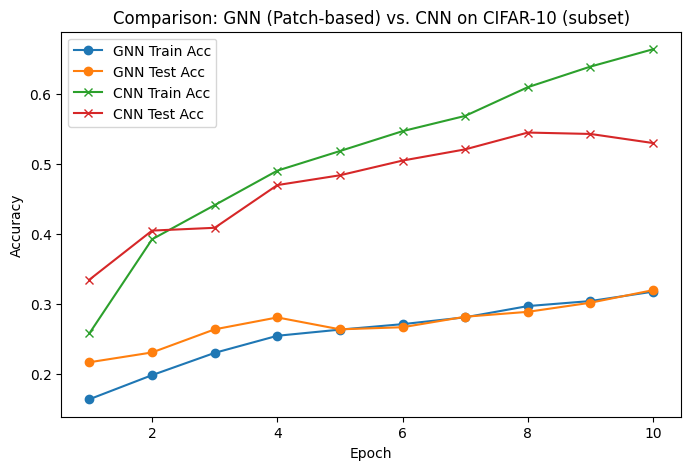

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import NearestNeighbors
import random

# -------------------------------------------------------------
# 1. 前処理設定 & データセット (CIFAR-10) の用意
# -------------------------------------------------------------
transform = T.Compose([
    T.ToTensor()
])
cifar_train = CIFAR10(root='.', train=True,  download=True, transform=transform)
cifar_test  = CIFAR10(root='.', train=False, download=True, transform=transform)

# 学習データを小規模に (例: 5000件だけ使用)
train_indices = list(range(5000))
test_indices  = list(range(1000))  # テストも1000件だけ使う
random.shuffle(train_indices)

train_subset = Subset(cifar_train, train_indices)
test_subset  = Subset(cifar_test, test_indices)

# ハイパーパラメータ
PATCH_SIZE = 4  # 4x4 パッチ
K = 5           # K近傍の数
H, W = 32, 32   # CIFAR-10の画像サイズ
C = 3           # カラーチャンネル

# 1画像あたりのパッチ数:  (H/PATCH_SIZE) * (W/PATCH_SIZE) = 8x8 = 64
NUM_PATCH_H = H // PATCH_SIZE
NUM_PATCH_W = W // PATCH_SIZE
NUM_NODES = NUM_PATCH_H * NUM_PATCH_W  # 64
PATCH_DIM = PATCH_SIZE * PATCH_SIZE * C  # 4x4x3 = 48


# -------------------------------------------------------------
# 2. 画像 -> パッチ分割 -> K近傍グラフ作成
# -------------------------------------------------------------
def image_to_graph(img_tensor):
    """
    img_tensor: shape (3, H, W) = (3,32,32)
    1) 4x4パッチに分割し、各パッチをフラット化 → (64, 48)
    2) 各パッチ間のK近傍を探し、edge_indexを作成
    3) PyG Dataオブジェクトを返す
    """
    # パッチ分割
    patches = []
    for i in range(NUM_PATCH_H):  # 0..7
        for j in range(NUM_PATCH_W):  # 0..7
            patch = img_tensor[:, 
                               i*PATCH_SIZE:(i+1)*PATCH_SIZE, 
                               j*PATCH_SIZE:(j+1)*PATCH_SIZE]  # shape: (3,4,4)
            patch_flat = patch.reshape(-1)  # (48,)
            patches.append(patch_flat)
    patches = torch.stack(patches, dim=0)  # shape: (64, 48)
    
    # patchesをnumpyに変換してKNNを実行
    patches_np = patches.numpy()
    nbrs = NearestNeighbors(n_neighbors=K+1, algorithm='ball_tree').fit(patches_np)
    # K+1 にしているのは、最近傍に必ず自分自身(距離0)が含まれるため
    distances, indices = nbrs.kneighbors(patches_np)
    
    # edge_index 作成
    # indices[i] はノード i の (K+1)近傍ノードID列 (先頭は i 自身)
    edge_list = []
    for i in range(NUM_NODES):
        # 1番目は自分自身(i)なので、2番目以降が「K近傍」
        neighbors = indices[i][1:]  # (K,)
        for nbr in neighbors:
            # 有向辺 (nbr -> i) とする (論文の記述に沿って)
            # 必要に応じて双方向 (i->nbr) も追加してもよい
            edge_list.append([nbr, i])
    
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()  # shape: (2, E)
    
    # PyG Data(x, edge_index)
    data = Data(x=patches, edge_index=edge_index)
    return data


# PyTorch Dataset 拡張:  __getitem__ で Graph Data を返す
class CifarGraphDataset(torch.utils.data.Dataset):
    def __init__(self, subset):
        self.subset = subset
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        # img: shape (3,32,32), label: int
        graph_data = image_to_graph(img)
        # y は画像のクラス
        graph_data.y = torch.tensor([label], dtype=torch.long)
        return graph_data

train_graph_dataset = CifarGraphDataset(train_subset)
test_graph_dataset  = CifarGraphDataset(test_subset)

# PyGのGeoDataLoaderでミニバッチ化
batch_size = 16
train_graph_loader = GeoDataLoader(train_graph_dataset, batch_size=batch_size, shuffle=True)
test_graph_loader  = GeoDataLoader(test_graph_dataset,  batch_size=batch_size, shuffle=False)


# -------------------------------------------------------------
# 3. GNNモデル (GCNConvで実装)
# -------------------------------------------------------------
from torch_geometric.nn import GCNConv, global_mean_pool

class PatchGNN(nn.Module):
    def __init__(self, in_dim=PATCH_DIM, hidden_dim=64, num_classes=10):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim)
        self.conv2 = GATConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x, edge_index, batch):
        # x: (total_nodes_in_batch, in_dim=48)
        # edge_index: (2, E)
        # batch: (total_nodes_in_batch,)  各ノードがどのグラフ(画像)に属するか
        
        x = self.conv1(x, edge_index)   # -> (hidden_dim)
        x = F.relu(x)
        x = self.conv2(x, edge_index)   # -> (hidden_dim)
        x = F.relu(x)
        
        # グローバルプーリング (mean)
        x = global_mean_pool(x, batch)  # -> (batch_size, hidden_dim)
        
        out = self.fc(x)                # -> (batch_size, 10)
        return out


# -------------------------------------------------------------
# 4. GNN の学習 (PatchGNN)
# -------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnn_model = PatchGNN().to(device)

optimizer = optim.Adam(gnn_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_gnn_epoch():
    gnn_model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for data in train_graph_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = gnn_model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * data.num_graphs
        
        preds = out.argmax(dim=1)
        total_correct += (preds == data.y).sum().item()
        total_samples += data.num_graphs
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

@torch.no_grad()
def eval_gnn(loader):
    gnn_model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for data in loader:
        data = data.to(device)
        out = gnn_model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        total_loss += loss.item() * data.num_graphs
        
        preds = out.argmax(dim=1)
        total_correct += (preds == data.y).sum().item()
        total_samples += data.num_graphs
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


# -------------------------------------------------------------
# 5. 通常のCNNモデルでの比較
# -------------------------------------------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # 入力: (3,32,32)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # x: (B,3,32,32)
        x = self.pool(F.relu(self.conv1(x)))  # -> (B,32,16,16)
        x = self.pool(F.relu(self.conv2(x)))  # -> (B,64,8,8)
        x = x.view(x.size(0), -1)             # -> (B, 64*8*8)
        x = F.relu(self.fc1(x))               # -> (B,128)
        out = self.fc2(x)                     # -> (B,10)
        return out

cnn_model = SimpleCNN().to(device)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=1e-3)
criterion_cnn = nn.CrossEntropyLoss()


# データローダ (通常のTensor)
#  - GNNとは別に、元のCIFAR-10の画像をそのままCNNに入力
train_loader_cnn = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader_cnn  = torch.utils.data.DataLoader(test_subset,  batch_size=64, shuffle=False)

def train_cnn_epoch():
    cnn_model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for (imgs, labels) in train_loader_cnn:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_cnn.zero_grad()
        out = cnn_model(imgs)
        loss = criterion_cnn(out, labels)
        loss.backward()
        optimizer_cnn.step()
        
        total_loss += loss.item() * imgs.size(0)
        preds = out.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

@torch.no_grad()
def eval_cnn(loader):
    cnn_model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for (imgs, labels) in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = cnn_model(imgs)
        loss = criterion_cnn(out, labels)
        total_loss += loss.item() * imgs.size(0)
        preds = out.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


# -------------------------------------------------------------
# 6. 学習ループ & 精度推移の可視化
# -------------------------------------------------------------
EPOCHS = 10

gnn_train_accs, gnn_test_accs = [], []
cnn_train_accs, cnn_test_accs = [], []

for epoch in range(1, EPOCHS+1):
    # --- GNN ---
    gnn_train_loss, gnn_train_acc = train_gnn_epoch()
    gnn_test_loss, gnn_test_acc   = eval_gnn(test_graph_loader)
    gnn_train_accs.append(gnn_train_acc)
    gnn_test_accs.append(gnn_test_acc)
    
    # --- CNN ---
    cnn_train_loss, cnn_train_acc = train_cnn_epoch()
    cnn_test_loss, cnn_test_acc   = eval_cnn(test_loader_cnn)
    cnn_train_accs.append(cnn_train_acc)
    cnn_test_accs.append(cnn_test_acc)

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"  [GNN ] train_acc={gnn_train_acc:.3f}, test_acc={gnn_test_acc:.3f}")
    print(f"  [CNN ] train_acc={cnn_train_acc:.3f}, test_acc={cnn_test_acc:.3f}")

# 可視化
epochs_range = range(1, EPOCHS+1)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, gnn_train_accs, label="GNN Train Acc", marker='o')
plt.plot(epochs_range, gnn_test_accs,  label="GNN Test Acc",  marker='o')
plt.plot(epochs_range, cnn_train_accs, label="CNN Train Acc", marker='x')
plt.plot(epochs_range, cnn_test_accs,  label="CNN Test Acc",  marker='x')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Comparison: GNN (Patch-based) vs. CNN on CIFAR-10 (subset)")
plt.legend()
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10
  [GNN ] train_acc=0.160, test_acc=0.190
  [CNN ] train_acc=0.202, test_acc=0.306
Epoch 2/10
  [GNN ] train_acc=0.209, test_acc=0.235
  [CNN ] train_acc=0.362, test_acc=0.419
Epoch 3/10
  [GNN ] train_acc=0.229, test_acc=0.271
  [CNN ] train_acc=0.430, test_acc=0.420
Epoch 4/10
  [GNN ] train_acc=0.253, test_acc=0.260
  [CNN ] train_acc=0.476, test_acc=0.442
Epoch 5/10
  [GNN ] train_acc=0.272, test_acc=0.267
  [CNN ] train_acc=0.488, test_acc=0.484
Epoch 6/10
  [GNN ] train_acc=0.277, test_acc=0.277
  [CNN ] train_acc=0.526, test_acc=0.513
Epoch 7/10
  [GNN ] train_acc=0.285, test_acc=0.279
  [CNN ] train_acc=0.555, test_acc=0.524
Epoch 8/10
  [GNN ] train_acc=0.297, test_acc=0.276
  [CNN ] train_acc=0.581, test_acc=0.509
Epoch 9/10
  [GNN ] train_acc=0.304, test_acc=0.309
  [CNN ] train_acc=0.606, test_acc=0.540
Epoch 10/10
  [GNN ] train_acc=0.314, test_acc=0.318
  [CNN ] train_acc=0.638, test_acc

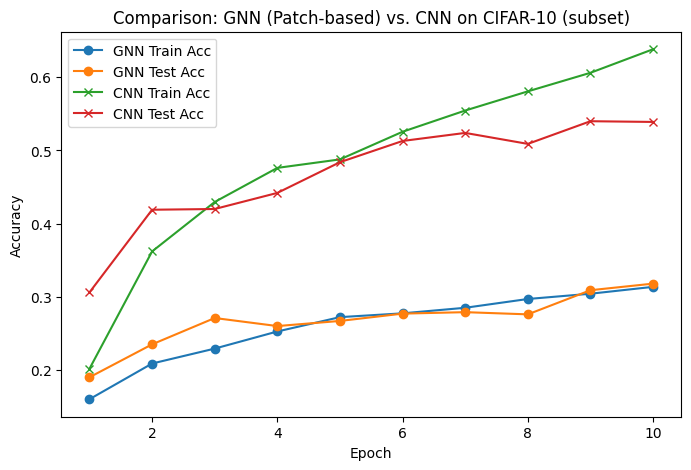

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import NearestNeighbors
import random

# -------------------------------------------------------------
# 1. 前処理設定 & データセット (CIFAR-10) の用意
# -------------------------------------------------------------
transform = T.Compose([
    T.ToTensor()
])
cifar_train = CIFAR10(root='.', train=True,  download=True, transform=transform)
cifar_test  = CIFAR10(root='.', train=False, download=True, transform=transform)

# 学習データを小規模に (例: 5000件だけ使用)
train_indices = list(range(5000))
test_indices  = list(range(1000))  # テストも1000件だけ使う
random.shuffle(train_indices)

train_subset = Subset(cifar_train, train_indices)
test_subset  = Subset(cifar_test, test_indices)

# ハイパーパラメータ
PATCH_SIZE = 4  # 4x4 パッチ
K = 3           # K近傍の数
H, W = 32, 32   # CIFAR-10の画像サイズ
C = 3           # カラーチャンネル

# 1画像あたりのパッチ数:  (H/PATCH_SIZE) * (W/PATCH_SIZE) = 8x8 = 64
NUM_PATCH_H = H // PATCH_SIZE
NUM_PATCH_W = W // PATCH_SIZE
NUM_NODES = NUM_PATCH_H * NUM_PATCH_W  # 64
PATCH_DIM = PATCH_SIZE * PATCH_SIZE * C  # 4x4x3 = 48


# -------------------------------------------------------------
# 2. 画像 -> パッチ分割 -> K近傍グラフ作成
# -------------------------------------------------------------
def image_to_graph(img_tensor):
    """
    img_tensor: shape (3, H, W) = (3,32,32)
    1) 4x4パッチに分割し、各パッチをフラット化 → (64, 48)
    2) 各パッチ間のK近傍を探し、edge_indexを作成
    3) PyG Dataオブジェクトを返す
    """
    # パッチ分割
    patches = []
    for i in range(NUM_PATCH_H):  # 0..7
        for j in range(NUM_PATCH_W):  # 0..7
            patch = img_tensor[:, 
                               i*PATCH_SIZE:(i+1)*PATCH_SIZE, 
                               j*PATCH_SIZE:(j+1)*PATCH_SIZE]  # shape: (3,4,4)
            patch_flat = patch.reshape(-1)  # (48,)
            patches.append(patch_flat)
    patches = torch.stack(patches, dim=0)  # shape: (64, 48)
    
    # patchesをnumpyに変換してKNNを実行
    patches_np = patches.numpy()
    nbrs = NearestNeighbors(n_neighbors=K+1, algorithm='ball_tree').fit(patches_np)
    # K+1 にしているのは、最近傍に必ず自分自身(距離0)が含まれるため
    distances, indices = nbrs.kneighbors(patches_np)
    
    # edge_index 作成
    # indices[i] はノード i の (K+1)近傍ノードID列 (先頭は i 自身)
    edge_list = []
    for i in range(NUM_NODES):
        # 1番目は自分自身(i)なので、2番目以降が「K近傍」
        neighbors = indices[i][1:]  # (K,)
        for nbr in neighbors:
            # 有向辺 (nbr -> i) とする (論文の記述に沿って)
            # 必要に応じて双方向 (i->nbr) も追加してもよい
            edge_list.append([nbr, i])
    
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()  # shape: (2, E)
    
    # PyG Data(x, edge_index)
    data = Data(x=patches, edge_index=edge_index)
    return data


# PyTorch Dataset 拡張:  __getitem__ で Graph Data を返す
class CifarGraphDataset(torch.utils.data.Dataset):
    def __init__(self, subset):
        self.subset = subset
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        # img: shape (3,32,32), label: int
        graph_data = image_to_graph(img)
        # y は画像のクラス
        graph_data.y = torch.tensor([label], dtype=torch.long)
        return graph_data

train_graph_dataset = CifarGraphDataset(train_subset)
test_graph_dataset  = CifarGraphDataset(test_subset)

# PyGのGeoDataLoaderでミニバッチ化
batch_size = 16
train_graph_loader = GeoDataLoader(train_graph_dataset, batch_size=batch_size, shuffle=True)
test_graph_loader  = GeoDataLoader(test_graph_dataset,  batch_size=batch_size, shuffle=False)


# -------------------------------------------------------------
# 3. GNNモデル (GCNConvで実装)
# -------------------------------------------------------------
from torch_geometric.nn import GCNConv, global_mean_pool

class PatchGNN(nn.Module):
    def __init__(self, in_dim=PATCH_DIM, hidden_dim=64, num_classes=10):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim)
        self.conv2 = GATConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x, edge_index, batch):
        # x: (total_nodes_in_batch, in_dim=48)
        # edge_index: (2, E)
        # batch: (total_nodes_in_batch,)  各ノードがどのグラフ(画像)に属するか
        
        x = self.conv1(x, edge_index)   # -> (hidden_dim)
        x = F.relu(x)
        x = self.conv2(x, edge_index)   # -> (hidden_dim)
        x = F.relu(x)
        
        # グローバルプーリング (mean)
        x = global_mean_pool(x, batch)  # -> (batch_size, hidden_dim)
        
        out = self.fc(x)                # -> (batch_size, 10)
        return out


# -------------------------------------------------------------
# 4. GNN の学習 (PatchGNN)
# -------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnn_model = PatchGNN().to(device)

optimizer = optim.Adam(gnn_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_gnn_epoch():
    gnn_model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for data in train_graph_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = gnn_model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * data.num_graphs
        
        preds = out.argmax(dim=1)
        total_correct += (preds == data.y).sum().item()
        total_samples += data.num_graphs
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

@torch.no_grad()
def eval_gnn(loader):
    gnn_model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for data in loader:
        data = data.to(device)
        out = gnn_model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        total_loss += loss.item() * data.num_graphs
        
        preds = out.argmax(dim=1)
        total_correct += (preds == data.y).sum().item()
        total_samples += data.num_graphs
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


# -------------------------------------------------------------
# 5. 通常のCNNモデルでの比較
# -------------------------------------------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # 入力: (3,32,32)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # x: (B,3,32,32)
        x = self.pool(F.relu(self.conv1(x)))  # -> (B,32,16,16)
        x = self.pool(F.relu(self.conv2(x)))  # -> (B,64,8,8)
        x = x.view(x.size(0), -1)             # -> (B, 64*8*8)
        x = F.relu(self.fc1(x))               # -> (B,128)
        out = self.fc2(x)                     # -> (B,10)
        return out

cnn_model = SimpleCNN().to(device)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=1e-3)
criterion_cnn = nn.CrossEntropyLoss()


# データローダ (通常のTensor)
#  - GNNとは別に、元のCIFAR-10の画像をそのままCNNに入力
train_loader_cnn = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader_cnn  = torch.utils.data.DataLoader(test_subset,  batch_size=64, shuffle=False)

def train_cnn_epoch():
    cnn_model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for (imgs, labels) in train_loader_cnn:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_cnn.zero_grad()
        out = cnn_model(imgs)
        loss = criterion_cnn(out, labels)
        loss.backward()
        optimizer_cnn.step()
        
        total_loss += loss.item() * imgs.size(0)
        preds = out.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

@torch.no_grad()
def eval_cnn(loader):
    cnn_model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for (imgs, labels) in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = cnn_model(imgs)
        loss = criterion_cnn(out, labels)
        total_loss += loss.item() * imgs.size(0)
        preds = out.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


# -------------------------------------------------------------
# 6. 学習ループ & 精度推移の可視化
# -------------------------------------------------------------
EPOCHS = 10

gnn_train_accs, gnn_test_accs = [], []
cnn_train_accs, cnn_test_accs = [], []

for epoch in range(1, EPOCHS+1):
    # --- GNN ---
    gnn_train_loss, gnn_train_acc = train_gnn_epoch()
    gnn_test_loss, gnn_test_acc   = eval_gnn(test_graph_loader)
    gnn_train_accs.append(gnn_train_acc)
    gnn_test_accs.append(gnn_test_acc)
    
    # --- CNN ---
    cnn_train_loss, cnn_train_acc = train_cnn_epoch()
    cnn_test_loss, cnn_test_acc   = eval_cnn(test_loader_cnn)
    cnn_train_accs.append(cnn_train_acc)
    cnn_test_accs.append(cnn_test_acc)

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"  [GNN ] train_acc={gnn_train_acc:.3f}, test_acc={gnn_test_acc:.3f}")
    print(f"  [CNN ] train_acc={cnn_train_acc:.3f}, test_acc={cnn_test_acc:.3f}")

# 可視化
epochs_range = range(1, EPOCHS+1)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, gnn_train_accs, label="GNN Train Acc", marker='o')
plt.plot(epochs_range, gnn_test_accs,  label="GNN Test Acc",  marker='o')
plt.plot(epochs_range, cnn_train_accs, label="CNN Train Acc", marker='x')
plt.plot(epochs_range, cnn_test_accs,  label="CNN Test Acc",  marker='x')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Comparison: GNN (Patch-based) vs. CNN on CIFAR-10 (subset)")
plt.legend()
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10
  [GNN ] train_acc=0.157, test_acc=0.198
  [CNN ] train_acc=0.244, test_acc=0.362
Epoch 2/10
  [GNN ] train_acc=0.200, test_acc=0.228
  [CNN ] train_acc=0.399, test_acc=0.394
Epoch 3/10
  [GNN ] train_acc=0.214, test_acc=0.259
  [CNN ] train_acc=0.459, test_acc=0.459
Epoch 4/10
  [GNN ] train_acc=0.263, test_acc=0.275
  [CNN ] train_acc=0.507, test_acc=0.502
Epoch 5/10
  [GNN ] train_acc=0.296, test_acc=0.319
  [CNN ] train_acc=0.537, test_acc=0.531
Epoch 6/10
  [GNN ] train_acc=0.310, test_acc=0.314
  [CNN ] train_acc=0.565, test_acc=0.527
Epoch 7/10
  [GNN ] train_acc=0.312, test_acc=0.324
  [CNN ] train_acc=0.597, test_acc=0.536
Epoch 8/10
  [GNN ] train_acc=0.330, test_acc=0.329
  [CNN ] train_acc=0.624, test_acc=0.524
Epoch 9/10
  [GNN ] train_acc=0.323, test_acc=0.336
  [CNN ] train_acc=0.658, test_acc=0.552
Epoch 10/10
  [GNN ] train_acc=0.348, test_acc=0.338
  [CNN ] train_acc=0.678, test_acc

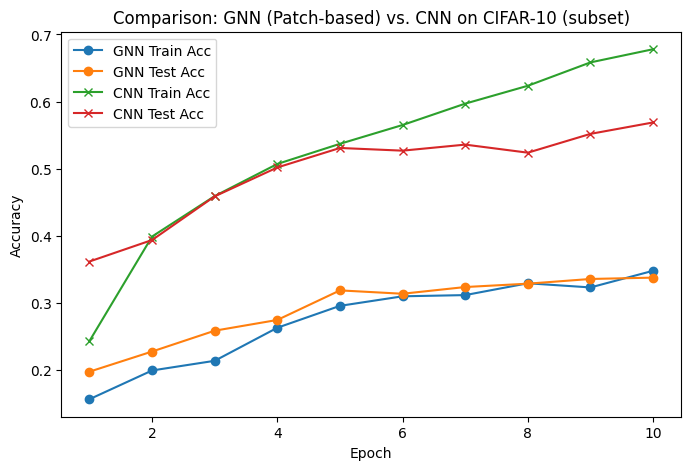

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import NearestNeighbors
import random

# -------------------------------------------------------------
# 1. 前処理設定 & データセット (CIFAR-10) の用意
# -------------------------------------------------------------
transform = T.Compose([
    T.ToTensor()
])
cifar_train = CIFAR10(root='.', train=True,  download=True, transform=transform)
cifar_test  = CIFAR10(root='.', train=False, download=True, transform=transform)

# 学習データを小規模に (例: 5000件だけ使用)
train_indices = list(range(5000))
test_indices  = list(range(1000))  # テストも1000件だけ使う
random.shuffle(train_indices)

train_subset = Subset(cifar_train, train_indices)
test_subset  = Subset(cifar_test, test_indices)

# ハイパーパラメータ
PATCH_SIZE = 4  # 4x4 パッチ
K = 5           # K近傍の数
H, W = 32, 32   # CIFAR-10の画像サイズ
C = 3           # カラーチャンネル

# 1画像あたりのパッチ数:  (H/PATCH_SIZE) * (W/PATCH_SIZE) = 8x8 = 64
NUM_PATCH_H = H // PATCH_SIZE
NUM_PATCH_W = W // PATCH_SIZE
NUM_NODES = NUM_PATCH_H * NUM_PATCH_W  # 64
PATCH_DIM = PATCH_SIZE * PATCH_SIZE * C  # 4x4x3 = 48


# -------------------------------------------------------------
# 2. 画像 -> パッチ分割 -> K近傍グラフ作成
# -------------------------------------------------------------
import torch.nn.functional as F

def image_to_graph(img_tensor, patch_size=4, K=5, padding=2):
    """
    img_tensor : shape (C, H, W) = (3, 32, 32)など
    patch_size : 取り出すパッチのサイズ (4x4, etc)
    K          : K近傍の数
    padding    : ゼロパディングのサイズ
    """
    # -----------------------------
    # 1) 画像にゼロパディングを実施
    # -----------------------------
    # F.padの引数: (left, right, top, bottom)
    # ここでは上下左右すべて `padding` だけゼロを詰める
    if padding > 0:
        img_tensor = F.pad(img_tensor, (padding, padding, padding, padding), mode='constant', value=0)
    
    # 新しい高さ・幅
    C, Hp, Wp = img_tensor.shape  
    # 例: padding=2 なら、元が32x32 -> (32+2+2)=36x36

    # -----------------------------
    # 2) パッチ分割
    # -----------------------------
    # H方向、W方向をそれぞれ patch_size ずつ区切っていく
    NUM_PATCH_H = Hp // patch_size
    NUM_PATCH_W = Wp // patch_size
    num_nodes = NUM_PATCH_H * NUM_PATCH_W
    patch_dim = patch_size * patch_size * C
    
    patches = []
    for i in range(NUM_PATCH_H):
        for j in range(NUM_PATCH_W):
            patch = img_tensor[:, 
                               i*patch_size:(i+1)*patch_size, 
                               j*patch_size:(j+1)*patch_size]  
            # shape: (C, patch_size, patch_size)
            
            # メモリ不連続エラーを避けるため、reshape(-1)推奨
            patch_flat = patch.reshape(-1)  # (patch_dim,)
            patches.append(patch_flat)
    
    patches = torch.stack(patches, dim=0)  # shape: (num_nodes, patch_dim)

    # -----------------------------
    # 3) K近傍グラフの構築
    # -----------------------------
    from sklearn.neighbors import NearestNeighbors
    import numpy as np
    
    patches_np = patches.numpy()
    nbrs = NearestNeighbors(n_neighbors=K+1, algorithm='auto').fit(patches_np)
    distances, indices = nbrs.kneighbors(patches_np)
    
    edge_list = []
    for i in range(num_nodes):
        # 0番目は自分自身なのでスキップ
        neighbors = indices[i][1:]  # shape: (K,)
        for nbr in neighbors:
            edge_list.append([nbr, i])  # (nbr -> i) の有向辺

    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()  # shape: (2, E)
    
    # -----------------------------
    # 4) PyGのDataで返す
    # -----------------------------
    from torch_geometric.data import Data
    data = Data(x=patches, edge_index=edge_index)
    return data



# PyTorch Dataset 拡張:  __getitem__ で Graph Data を返す
class CifarGraphDataset(torch.utils.data.Dataset):
    def __init__(self, subset):
        self.subset = subset
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        # img: shape (3,32,32), label: int
        graph_data = image_to_graph(img)
        # y は画像のクラス
        graph_data.y = torch.tensor([label], dtype=torch.long)
        return graph_data

train_graph_dataset = CifarGraphDataset(train_subset)
test_graph_dataset  = CifarGraphDataset(test_subset)

# PyGのGeoDataLoaderでミニバッチ化
batch_size = 16
train_graph_loader = GeoDataLoader(train_graph_dataset, batch_size=batch_size, shuffle=True)
test_graph_loader  = GeoDataLoader(test_graph_dataset,  batch_size=batch_size, shuffle=False)


# -------------------------------------------------------------
# 3. GNNモデル (GCNConvで実装)
# -------------------------------------------------------------
from torch_geometric.nn import GCNConv, global_mean_pool

class PatchGNN(nn.Module):
    def __init__(self, in_dim=PATCH_DIM, hidden_dim=64, num_classes=10):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim)
        self.conv2 = GATConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x, edge_index, batch):
        # x: (total_nodes_in_batch, in_dim=48)
        # edge_index: (2, E)
        # batch: (total_nodes_in_batch,)  各ノードがどのグラフ(画像)に属するか
        
        x = self.conv1(x, edge_index)   # -> (hidden_dim)
        x = F.relu(x)
        x = self.conv2(x, edge_index)   # -> (hidden_dim)
        x = F.relu(x)
        
        # グローバルプーリング (mean)
        x = global_mean_pool(x, batch)  # -> (batch_size, hidden_dim)
        
        out = self.fc(x)                # -> (batch_size, 10)
        return out


# -------------------------------------------------------------
# 4. GNN の学習 (PatchGNN)
# -------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnn_model = PatchGNN().to(device)

optimizer = optim.Adam(gnn_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_gnn_epoch():
    gnn_model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for data in train_graph_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = gnn_model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * data.num_graphs
        
        preds = out.argmax(dim=1)
        total_correct += (preds == data.y).sum().item()
        total_samples += data.num_graphs
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

@torch.no_grad()
def eval_gnn(loader):
    gnn_model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for data in loader:
        data = data.to(device)
        out = gnn_model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        total_loss += loss.item() * data.num_graphs
        
        preds = out.argmax(dim=1)
        total_correct += (preds == data.y).sum().item()
        total_samples += data.num_graphs
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


# -------------------------------------------------------------
# 5. 通常のCNNモデルでの比較
# -------------------------------------------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # 入力: (3,32,32)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # x: (B,3,32,32)
        x = self.pool(F.relu(self.conv1(x)))  # -> (B,32,16,16)
        x = self.pool(F.relu(self.conv2(x)))  # -> (B,64,8,8)
        x = x.view(x.size(0), -1)             # -> (B, 64*8*8)
        x = F.relu(self.fc1(x))               # -> (B,128)
        out = self.fc2(x)                     # -> (B,10)
        return out

cnn_model = SimpleCNN().to(device)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=1e-3)
criterion_cnn = nn.CrossEntropyLoss()


# データローダ (通常のTensor)
#  - GNNとは別に、元のCIFAR-10の画像をそのままCNNに入力
train_loader_cnn = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader_cnn  = torch.utils.data.DataLoader(test_subset,  batch_size=64, shuffle=False)

def train_cnn_epoch():
    cnn_model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for (imgs, labels) in train_loader_cnn:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_cnn.zero_grad()
        out = cnn_model(imgs)
        loss = criterion_cnn(out, labels)
        loss.backward()
        optimizer_cnn.step()
        
        total_loss += loss.item() * imgs.size(0)
        preds = out.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

@torch.no_grad()
def eval_cnn(loader):
    cnn_model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for (imgs, labels) in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = cnn_model(imgs)
        loss = criterion_cnn(out, labels)
        total_loss += loss.item() * imgs.size(0)
        preds = out.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


# -------------------------------------------------------------
# 6. 学習ループ & 精度推移の可視化
# -------------------------------------------------------------
EPOCHS = 10

gnn_train_accs, gnn_test_accs = [], []
cnn_train_accs, cnn_test_accs = [], []

for epoch in range(1, EPOCHS+1):
    # --- GNN ---
    gnn_train_loss, gnn_train_acc = train_gnn_epoch()
    gnn_test_loss, gnn_test_acc   = eval_gnn(test_graph_loader)
    gnn_train_accs.append(gnn_train_acc)
    gnn_test_accs.append(gnn_test_acc)
    
    # --- CNN ---
    cnn_train_loss, cnn_train_acc = train_cnn_epoch()
    cnn_test_loss, cnn_test_acc   = eval_cnn(test_loader_cnn)
    cnn_train_accs.append(cnn_train_acc)
    cnn_test_accs.append(cnn_test_acc)

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"  [GNN ] train_acc={gnn_train_acc:.3f}, test_acc={gnn_test_acc:.3f}")
    print(f"  [CNN ] train_acc={cnn_train_acc:.3f}, test_acc={cnn_test_acc:.3f}")

# 可視化
epochs_range = range(1, EPOCHS+1)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, gnn_train_accs, label="GNN Train Acc", marker='o')
plt.plot(epochs_range, gnn_test_accs,  label="GNN Test Acc",  marker='o')
plt.plot(epochs_range, cnn_train_accs, label="CNN Train Acc", marker='x')
plt.plot(epochs_range, cnn_test_accs,  label="CNN Test Acc",  marker='x')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Comparison: GNN (Patch-based) vs. CNN on CIFAR-10 (subset)")
plt.legend()
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10]
  GNN train_acc=0.164  test_acc=0.178
  CNN train_acc=0.249  test_acc=0.366
Epoch [2/10]
  GNN train_acc=0.222  test_acc=0.231
  CNN train_acc=0.386  test_acc=0.398
Epoch [3/10]
  GNN train_acc=0.233  test_acc=0.273
  CNN train_acc=0.428  test_acc=0.421
Epoch [4/10]
  GNN train_acc=0.237  test_acc=0.274
  CNN train_acc=0.480  test_acc=0.468
Epoch [5/10]
  GNN train_acc=0.250  test_acc=0.283
  CNN train_acc=0.516  test_acc=0.493
Epoch [6/10]
  GNN train_acc=0.269  test_acc=0.293
  CNN train_acc=0.553  test_acc=0.508
Epoch [7/10]
  GNN train_acc=0.278  test_acc=0.292
  CNN train_acc=0.579  test_acc=0.529
Epoch [8/10]
  GNN train_acc=0.295  test_acc=0.331
  CNN train_acc=0.600  test_acc=0.530
Epoch [9/10]
  GNN train_acc=0.300  test_acc=0.337
  CNN train_acc=0.633  test_acc=0.543
Epoch [10/10]
  GNN train_acc=0.306  test_acc=0.279
  CNN train_acc=0.667  test_acc=0.549


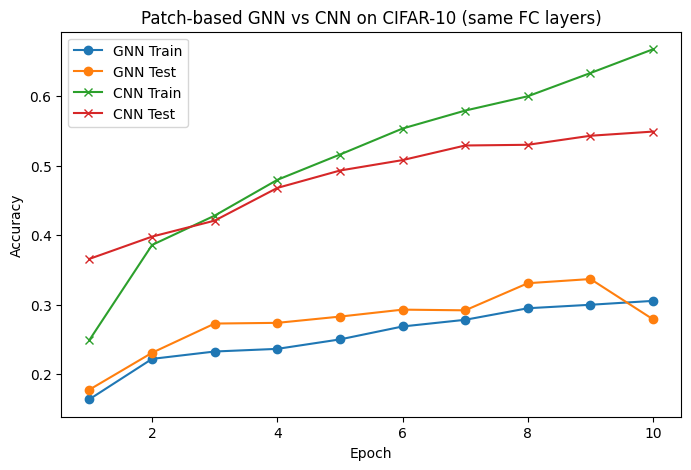

In [9]:
#モデルの内容をカーネルのところ以外を同じにする。

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np
import random

# ======================
# 1. データセット準備
# ======================
transform = T.Compose([
    T.ToTensor()
])
cifar_train = CIFAR10(root='.', train=True, download=True, transform=transform)
cifar_test  = CIFAR10(root='.', train=False, download=True, transform=transform)

# 小規模に (train=5000, test=1000)
train_indices = list(range(5000))
test_indices  = list(range(1000))
random.shuffle(train_indices)

train_subset = Subset(cifar_train, train_indices)
test_subset  = Subset(cifar_test, test_indices)


# ======================================================
# 2. GNN: 画像をパッチ分割 + K近傍グラフ構築する Dataset
# ======================================================
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeoDataLoader

from sklearn.neighbors import NearestNeighbors

# パッチサイズやKの設定
PATCH_SIZE = 4   # 4×4パッチ
K = 5            # K近傍
C, H, W = 3, 32, 32
NUM_PATCH_H = H // PATCH_SIZE  # 8
NUM_PATCH_W = W // PATCH_SIZE  # 8
NUM_NODES = NUM_PATCH_H * NUM_PATCH_W  # 64
PATCH_DIM = PATCH_SIZE * PATCH_SIZE * C  # 4*4*3 = 48

def image_to_graph(img_tensor):
    """
    img_tensor: shape (3, 32, 32)
    1) 4x4パッチに分割 (計64)
    2) 各パッチを 48次元にflatten
    3) K近傍でエッジ作成
    4) PyG Data(x, edge_index) で返す
    """
    patches = []
    for i in range(NUM_PATCH_H):
        for j in range(NUM_PATCH_W):
            patch = img_tensor[:, i*PATCH_SIZE:(i+1)*PATCH_SIZE, j*PATCH_SIZE:(j+1)*PATCH_SIZE]
            patch_flat = patch.reshape(-1)  # reshape推奨 (非連続対応)
            patches.append(patch_flat)
    patches = torch.stack(patches, dim=0)  # (64,48)
    
    # K近傍でエッジ作成
    patches_np = patches.numpy()
    nbrs = NearestNeighbors(n_neighbors=K+1, algorithm='auto').fit(patches_np)
    distances, indices = nbrs.kneighbors(patches_np)
    edge_list = []
    for i in range(NUM_NODES):
        neighbors = indices[i][1:]  # 0番目は自分自身
        for nbr in neighbors:
            edge_list.append([nbr, i])  # (nbr -> i) の有向辺
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    data = Data(x=patches, edge_index=edge_index)
    return data

class CifarGraphDataset(torch.utils.data.Dataset):
    def __init__(self, subset):
        self.subset = subset
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        graph_data = image_to_graph(img)  # (64,48) with edge_index
        graph_data.y = torch.tensor([label], dtype=torch.long)
        return graph_data

train_graph_dataset = CifarGraphDataset(train_subset)
test_graph_dataset  = CifarGraphDataset(test_subset)

gnn_batch_size = 16
train_graph_loader = GeoDataLoader(train_graph_dataset, batch_size=gnn_batch_size, shuffle=True)
test_graph_loader  = GeoDataLoader(test_graph_dataset,  batch_size=gnn_batch_size, shuffle=False)

# ======================================================
# 3. GNNモデル定義（全結合部分は2層MLP）
# ======================================================
from torch_geometric.nn import GCNConv, global_mean_pool

class PatchGNN(nn.Module):
    def __init__(self, in_dim=PATCH_DIM, hidden_dim=64, fc_hidden=128, num_classes=10):
        super().__init__()
        # --- GNN部: 2層GCNConv ---
        self.gcn1 = GCNConv(in_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        
        # --- 全結合部: 2層MLP ---
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, fc_hidden),
            nn.ReLU(),
            nn.Linear(fc_hidden, num_classes)
        )
        
    def forward(self, x, edge_index, batch):
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = self.gcn2(x, edge_index)
        x = F.relu(x)
        
        # グローバルプーリング (各グラフ単位で平均)
        x = global_mean_pool(x, batch)  # (batch_size, hidden_dim)
        
        out = self.mlp(x)  # (batch_size, num_classes)
        return out

# GNNモデルのインスタンス
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnn_model = PatchGNN().to(device)

gnn_optimizer = optim.Adam(gnn_model.parameters(), lr=1e-3)
gnn_criterion = nn.CrossEntropyLoss()


def train_gnn_epoch():
    gnn_model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for data in train_graph_loader:
        data = data.to(device)
        gnn_optimizer.zero_grad()
        
        out = gnn_model(data.x, data.edge_index, data.batch)
        loss = gnn_criterion(out, data.y)
        loss.backward()
        gnn_optimizer.step()
        
        preds = out.argmax(dim=1)
        correct = (preds == data.y).sum().item()
        
        total_loss += loss.item() * data.num_graphs
        total_correct += correct
        total_samples += data.num_graphs
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

@torch.no_grad()
def eval_gnn(loader):
    gnn_model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for data in loader:
        data = data.to(device)
        out = gnn_model(data.x, data.edge_index, data.batch)
        loss = gnn_criterion(out, data.y)
        
        preds = out.argmax(dim=1)
        correct = (preds == data.y).sum().item()
        
        total_loss += loss.item() * data.num_graphs
        total_correct += correct
        total_samples += data.num_graphs
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


# ======================================================
# 4. CNNモデル定義（全結合部分は2層MLP）
# ======================================================
class SimpleCNN(nn.Module):
    def __init__(self, fc_hidden=128, num_classes=10):
        super().__init__()
        # --- CNN部: 2層Conv2d ---
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # 2×2プーリング
        
        # --- 全結合部: 2層MLP ---
        # 最終的に (B, 64, 8, 8) まで縮小 => 64*8*8=4096
        self.mlp = nn.Sequential(
            nn.Linear(64*8*8, fc_hidden),
            nn.ReLU(),
            nn.Linear(fc_hidden, num_classes)
        )
    
    def forward(self, x):
        # x: (B, 3, 32, 32)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)  # -> (B, 32, 16, 16)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)  # -> (B, 64, 8, 8)
        
        x = x.view(x.size(0), -1)  # -> (B, 64*8*8)
        out = self.mlp(x)          # -> (B, num_classes)
        return out

cnn_model = SimpleCNN().to(device)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)
cnn_criterion = nn.CrossEntropyLoss()

# DataLoader (通常のTensor版)
cnn_batch_size = 64
train_loader_cnn = torch.utils.data.DataLoader(train_subset, batch_size=cnn_batch_size, shuffle=True)
test_loader_cnn  = torch.utils.data.DataLoader(test_subset,  batch_size=cnn_batch_size, shuffle=False)

def train_cnn_epoch():
    cnn_model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for (imgs, labels) in train_loader_cnn:
        imgs, labels = imgs.to(device), labels.to(device)
        cnn_optimizer.zero_grad()
        
        out = cnn_model(imgs)
        loss = cnn_criterion(out, labels)
        loss.backward()
        cnn_optimizer.step()
        
        preds = out.argmax(dim=1)
        correct = (preds == labels).sum().item()
        
        total_loss += loss.item() * imgs.size(0)
        total_correct += correct
        total_samples += imgs.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

@torch.no_grad()
def eval_cnn(loader):
    cnn_model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for (imgs, labels) in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = cnn_model(imgs)
        loss = cnn_criterion(out, labels)
        
        preds = out.argmax(dim=1)
        correct = (preds == labels).sum().item()
        
        total_loss += loss.item() * imgs.size(0)
        total_correct += correct
        total_samples += imgs.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


# ======================================================
# 5. 学習＆比較
# ======================================================
EPOCHS = 10
gnn_train_accs, gnn_test_accs = [], []
cnn_train_accs, cnn_test_accs = [], []

for epoch in range(1, EPOCHS+1):
    # --- GNN ---
    gnn_train_loss, gnn_train_acc = train_gnn_epoch()
    gnn_test_loss,  gnn_test_acc  = eval_gnn(test_graph_loader)
    gnn_train_accs.append(gnn_train_acc)
    gnn_test_accs.append(gnn_test_acc)
    
    # --- CNN ---
    cnn_train_loss, cnn_train_acc = train_cnn_epoch()
    cnn_test_loss,  cnn_test_acc  = eval_cnn(test_loader_cnn)
    cnn_train_accs.append(cnn_train_acc)
    cnn_test_accs.append(cnn_test_acc)
    
    print(f"Epoch [{epoch}/{EPOCHS}]")
    print(f"  GNN train_acc={gnn_train_acc:.3f}  test_acc={gnn_test_acc:.3f}")
    print(f"  CNN train_acc={cnn_train_acc:.3f}  test_acc={cnn_test_acc:.3f}")

# 学習曲線の可視化
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1,EPOCHS+1), gnn_train_accs, label="GNN Train", marker='o')
plt.plot(range(1,EPOCHS+1), gnn_test_accs,  label="GNN Test",  marker='o')
plt.plot(range(1,EPOCHS+1), cnn_train_accs, label="CNN Train", marker='x')
plt.plot(range(1,EPOCHS+1), cnn_test_accs,  label="CNN Test",  marker='x')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Patch-based GNN vs CNN on CIFAR-10 (same FC layers)")
plt.legend()
plt.show()


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class PatchGNN1Layer(nn.Module):
    def __init__(self, in_dim=48, hidden_dim=64, fc_hidden=128, num_classes=10):
        super().__init__()
        # --- GNN部: 1層GCNConv ---
        self.gcn = GCNConv(in_dim, hidden_dim)
        
        # --- 全結合部: 2層MLP ---
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, fc_hidden),
            nn.ReLU(),
            nn.Linear(fc_hidden, num_classes)
        )
        
    def forward(self, x, edge_index, batch):
        # 1層GCNConv → ReLU
        x = self.gcn(x, edge_index)
        x = F.relu(x)
        
        # グローバルプーリング
        x = global_mean_pool(x, batch)  # (batch_size, hidden_dim)
        
        # MLP
        out = self.mlp(x)               # (batch_size, num_classes)
        return out


# ・・・前処理・データセットのコードはそのまま・・・

# === 1. GNNモデルを1層に変更 ===
gnn_model_1layer = PatchGNN1Layer(
    in_dim=PATCH_DIM,    # =48
    hidden_dim=64, 
    fc_hidden=128, 
    num_classes=10
).to(device)

optimizer_1layer = torch.optim.Adam(gnn_model_1layer.parameters(), lr=1e-3)
criterion_1layer = nn.CrossEntropyLoss()

def train_gnn_1layer_epoch():
    gnn_model_1layer.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for data in train_graph_loader:
        data = data.to(device)
        optimizer_1layer.zero_grad()
        
        out = gnn_model_1layer(data.x, data.edge_index, data.batch)
        loss = criterion_1layer(out, data.y)
        loss.backward()
        optimizer_1layer.step()
        
        preds = out.argmax(dim=1)
        correct = (preds == data.y).sum().item()
        
        total_loss += loss.item() * data.num_graphs
        total_correct += correct
        total_samples += data.num_graphs
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

@torch.no_grad()
def eval_gnn_1layer(loader):
    gnn_model_1layer.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for data in loader:
        data = data.to(device)
        out = gnn_model_1layer(data.x, data.edge_index, data.batch)
        loss = criterion_1layer(out, data.y)
        
        preds = out.argmax(dim=1)
        correct = (preds == data.y).sum().item()
        
        total_loss += loss.item() * data.num_graphs
        total_correct += correct
        total_samples += data.num_graphs
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

# === 2. 学習実行 (例: EPOCHS=10) ===
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train_gnn_1layer_epoch()
    test_loss, test_acc   = eval_gnn_1layer(test_graph_loader)
    print(f"Epoch [{epoch}/{EPOCHS}]  train_acc={train_acc:.3f}, test_acc={test_acc:.3f}")


Epoch [1/10]  train_acc=0.163, test_acc=0.195
Epoch [2/10]  train_acc=0.194, test_acc=0.188
Epoch [3/10]  train_acc=0.218, test_acc=0.237
Epoch [4/10]  train_acc=0.231, test_acc=0.229
Epoch [5/10]  train_acc=0.248, test_acc=0.265
Epoch [6/10]  train_acc=0.256, test_acc=0.274
Epoch [7/10]  train_acc=0.274, test_acc=0.282
Epoch [8/10]  train_acc=0.282, test_acc=0.301
Epoch [9/10]  train_acc=0.289, test_acc=0.290
Epoch [10/10]  train_acc=0.290, test_acc=0.323


Files already downloaded and verified
Files already downloaded and verified
Epoch[1/5]
  GNN train_acc=0.163, test_acc=0.242
  CNN train_acc=0.203, test_acc=0.296
Epoch[2/5]
  GNN train_acc=0.204, test_acc=0.262
  CNN train_acc=0.326, test_acc=0.342
Epoch[3/5]
  GNN train_acc=0.217, test_acc=0.260
  CNN train_acc=0.419, test_acc=0.398
Epoch[4/5]
  GNN train_acc=0.236, test_acc=0.264
  CNN train_acc=0.452, test_acc=0.418
Epoch[5/5]
  GNN train_acc=0.248, test_acc=0.288
  CNN train_acc=0.488, test_acc=0.436


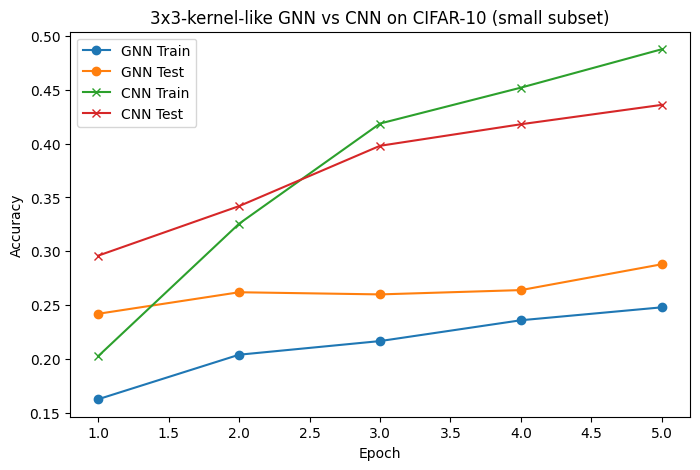

In [14]:
#上のコードは多分１：他のgnnになってない気がする。

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

import random
import numpy as np

# PyG関連
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------------------
# 1. データセット (CIFAR-10)
# ----------------------------
transform = T.Compose([T.ToTensor()])
cifar_train = CIFAR10(root='.', train=True,  download=True, transform=transform)
cifar_test  = CIFAR10(root='.', train=False, download=True, transform=transform)

train_indices = list(range(3000))  # 3000枚だけ使う (計算負荷を下げるため)
test_indices  = list(range(500))   # テストも500枚だけ
random.shuffle(train_indices)

train_subset = Subset(cifar_train, train_indices)
test_subset  = Subset(cifar_test, test_indices)

# ----------------------------
# 2. 3x3カーネル相当のグラフ構築関数
# ----------------------------
def image_to_graph_3x3kernel(img_tensor):
    """
    img_tensor: shape (3, H, W) = (3, 32, 32)
    1) ピクセルノード: H*W 個
       - ノードID = 0..(H*W -1)
       - 特徴量: RGB (3次元)
    2) 集約ノード: (H-2)*(W-2) 個
       - ノードID = H*W .. H*W + (H-2)*(W-2) - 1
       - 初期特徴量: 3次元のゼロベクトル (同じ次元にしておく)
    3) エッジ: 各集約ノードに対して、その 3x3 領域のピクセルノード -> 集約ノード へエッジを張る
       - 例: 集約ノード(0,0)には ピクセル(0..2,0..2) が入力
    """

    C, H, W = img_tensor.shape  # (3, 32, 32)
    assert C == 3, "CIFAR-10はチャンネル3のはずです"

    # ----- ピクセルノード特徴作成 -----
    # ピクセルノードID = row*W + col
    # 特徴量は (R, G, B) の3次元
    pixel_features = []
    for r in range(H):
        for c in range(W):
            # 画素値 (3,) を取り出し
            rgb = img_tensor[:, r, c]  # shape: (3,)
            pixel_features.append(rgb)
    pixel_features = torch.stack(pixel_features, dim=0)  # shape: (H*W, 3)

    # ----- 集約ノード特徴作成 -----
    # 集約ノードID = H*W + idx(0..(H-2)*(W-2)-1)
    # 初期特徴量は3次元のゼロベクトルに
    num_aggregators = (H-2)*(W-2)
    aggregator_features = torch.zeros(num_aggregators, 3)  # ( (H-2)*(W-2), 3 )

    # ----- ノード特徴 x をまとめる -----
    # 合計ノード数 = H*W + (H-2)*(W-2)
    x = torch.cat([pixel_features, aggregator_features], dim=0)  # shape: (H*W + num_aggregators, 3)

    # ----- エッジの作成 (pixel -> aggregator) -----
    edge_list = []
    # aggregatorノードの (行,列) = (ar, ac) in [0..(H-3)], [0..(W-3)]
    # aggregatorノードID = H*W + (ar*(W-2) + ac)
    # 対応する 3x3 ピクセル = 行[r..r+2], 列[c..c+2]
    # pixelノードID = r*W + c
    for ar in range(H-2):       # 0..(H-3)
        for ac in range(W-2):   # 0..(W-3)
            aggr_id = H*W + (ar*(W-2) + ac)
            # 3x3 ピクセル領域
            for dr in range(3):
                for dc in range(3):
                    pr = ar + dr  # pixel row
                    pc = ac + dc  # pixel col
                    pixel_id = pr*W + pc
                    # エッジ (pixel_id -> aggr_id)
                    edge_list.append([pixel_id, aggr_id])
    
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()  # shape: (2, E)

    data = Data(x=x, edge_index=edge_index)
    # この時点ではバッチやyは設定しない。Dataset側でlabelをつける。
    return data


# PyTorch Dataset → PyG graph dataset
class Cifar3x3GraphDataset(torch.utils.data.Dataset):
    def __init__(self, subset):
        self.subset = subset
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        img, label = self.subset[idx]  # (3,32,32), label
        graph_data = image_to_graph_3x3kernel(img)
        graph_data.y = torch.tensor([label], dtype=torch.long)
        return graph_data

train_graph_dataset = Cifar3x3GraphDataset(train_subset)
test_graph_dataset  = Cifar3x3GraphDataset(test_subset)

gnn_batch_size = 8  # グラフが大きいのでバッチは小さめ
train_graph_loader = GeoDataLoader(train_graph_dataset, batch_size=gnn_batch_size, shuffle=True)
test_graph_loader  = GeoDataLoader(test_graph_dataset,  batch_size=gnn_batch_size, shuffle=False)


# -----------------------------
# 3. GNNモデル (3×3カーネル風)
# -----------------------------
class PatchGNN3x3Kernel(nn.Module):
    """
    - 入力ノード: ピクセル (R,G,B) + 集約ノード (初期 0ベクトル)
    - 1~2層 GCNConv でメッセージパッシング
    - その後, 集約ノードのみ取り出してグローバルプーリング
    - MLP で最終分類 (10クラス)
    """
    def __init__(self, hidden_dim=64, fc_hidden=128, num_classes=10):
        super().__init__()
        # GCNConv の in_dim, out_dim
        # 今回 xの次元は 3 (ピクセル/aggregatorノードとも3次元で統一)
        self.gcn1 = GATConv(3, hidden_dim)
        self.gcn2 = GATConv(hidden_dim, hidden_dim)

        # 2層 MLP
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, fc_hidden),
            nn.ReLU(),
            nn.Linear(fc_hidden, num_classes)
        )

    def forward(self, x, edge_index, batch):
        # x: (total_nodes_in_batch, 3)
        # edge_index: (2, E)
        # batch: (total_nodes_in_batch,) -> グラフのID (ミニバッチ対応)

        # --- 1層目 ---
        x = self.gcn1(x, edge_index)  # shape: (N, hidden_dim)
        x = F.relu(x)

        # --- 2層目 ---
        x = self.gcn2(x, edge_index)
        x = F.relu(x)

        # ==========================================
        # 集約ノードだけをプーリング対象にしたい！
        # ------------------------------------------
        # ピクセルノード = 0..(H*W -1)
        # 集約ノード     = H*W..(H*W + (H-2)*(W-2) -1)
        # ただしバッチ内で複数画像 (複数グラフ) をまとめているため、
        # ノード数は画像ごとに変わる。batch はグラフ単位のID。
        #
        # → PyGには "global_mean_pool" があるが、全ノードを対象にする。
        # → 集約ノードのみ取り出して pooling したい場合、マスクが必要。
        # ==========================================

        # step 1) ノード数を画像ごとに区切るため、`batch` が何番のグラフかを使う
        # step 2) 各グラフ内で、pixelノード数 = 32*32=1024, aggregatorノード数 = 900, 合計1924 nodes
        #         → aggregatorノードのID範囲 = [1024..1923]
        # しかしバッチでは複数画像分が連結されるので、
        #   1枚目: node index= [0..1923]
        #   2枚目: node index= [1924..3847]
        #   ...
        # というようにずれていく。

        # そこで下記の方法を使います:
        #  - "batch" で groupby し、それぞれのグラフのnode数を把握
        #  - 画像ごとにpixelノード/aggregatorノードを切り分ける
        #  - aggregatorノードの特徴ベクトルだけ取り出して pooling
        #
        # (簡易実装では、バッチサイズ=1 にする手もありますが、
        #  ここでは複数グラフ一括処理のためにやや複雑な方法を取ります)

        # ミニバッチ内で何個のグラフがあるか
        num_graphs = batch.max().item() + 1

        pooled_vectors = []
        for g_id in range(num_graphs):
            # グラフg_idに属するノードインデックスを抽出
            mask = (batch == g_id)
            x_g = x[mask]  # shape: (ノード数_in_g, hidden_dim)

            # CIFAR-10前提: H=32, W=32 → pixel=1024, aggregator=900
            # ノード数_in_g = 1924 のはず
            # 前半 [0..1023] がピクセル, 後半 [1024..1923] がaggregator
            # → aggregator部分だけ切り出し:
            #  (本来なら dynamicに (H*W) や (H-2)*(W-2) を計算すべき)
            #  ここでは固定サイズ 32x32=1024, aggregator=900 を仮定
            if x_g.shape[0] != 1924:
                # 万一他の画像サイズになった場合など
                raise ValueError(f"Unexpected node count: {x_g.shape[0]} != 1924")

            agg_x = x_g[1024:]  # shape: (900, hidden_dim) -> aggregatorノード

            # aggregatorノードを平均プーリング
            pooled_vec = agg_x.mean(dim=0)  # shape: (hidden_dim,)
            pooled_vectors.append(pooled_vec)

        # (num_graphs, hidden_dim)
        pooled = torch.stack(pooled_vectors, dim=0)

        # --- MLPで10クラス分類 ---
        out = self.mlp(pooled)  # shape: (num_graphs, num_classes)

        return out


# モデル定義
gnn_model = PatchGNN3x3Kernel().to(device)
gnn_optimizer = optim.Adam(gnn_model.parameters(), lr=1e-3)
gnn_criterion = nn.CrossEntropyLoss()


# -----------------------------
# 4. 学習ループ (GNN)
# -----------------------------
def train_gnn_epoch():
    gnn_model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for data in train_graph_loader:
        data = data.to(device)
        gnn_optimizer.zero_grad()
        
        out = gnn_model(data.x, data.edge_index, data.batch)
        loss = gnn_criterion(out, data.y)
        loss.backward()
        gnn_optimizer.step()
        
        preds = out.argmax(dim=1)
        correct = (preds == data.y).sum().item()
        total_loss += loss.item() * data.num_graphs
        total_correct += correct
        total_samples += data.num_graphs
    
    return total_loss / total_samples, total_correct / total_samples

@torch.no_grad()
def eval_gnn(loader):
    gnn_model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for data in loader:
        data = data.to(device)
        out = gnn_model(data.x, data.edge_index, data.batch)
        loss = gnn_criterion(out, data.y)
        
        preds = out.argmax(dim=1)
        correct = (preds == data.y).sum().item()
        total_loss += loss.item() * data.num_graphs
        total_correct += correct
        total_samples += data.num_graphs
    
    return total_loss / total_samples, total_correct / total_samples


# -----------------------------
# 5. CNN (同じ全結合層)
# -----------------------------
class SimpleCNN(nn.Module):
    def __init__(self, fc_hidden=128, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)

        self.mlp = nn.Sequential(
            nn.Linear(64*8*8, fc_hidden),
            nn.ReLU(),
            nn.Linear(fc_hidden, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)  # -> (B,32,16,16)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)  # -> (B,64,8,8)
        x = x.view(x.size(0), -1)
        out = self.mlp(x)
        return out

cnn_model = SimpleCNN().to(device)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)
cnn_criterion = nn.CrossEntropyLoss()

cnn_batch_size = 64
train_cnn_loader = torch.utils.data.DataLoader(train_subset, batch_size=cnn_batch_size, shuffle=True)
test_cnn_loader  = torch.utils.data.DataLoader(test_subset,  batch_size=cnn_batch_size, shuffle=False)

def train_cnn_epoch():
    cnn_model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for (imgs, labels) in train_cnn_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        cnn_optimizer.zero_grad()
        
        out = cnn_model(imgs)
        loss = cnn_criterion(out, labels)
        loss.backward()
        cnn_optimizer.step()
        
        preds = out.argmax(dim=1)
        correct = (preds == labels).sum().item()
        total_loss += loss.item() * imgs.size(0)
        total_correct += correct
        total_samples += imgs.size(0)
    
    return total_loss / total_samples, total_correct / total_samples

@torch.no_grad()
def eval_cnn(loader):
    cnn_model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for (imgs, labels) in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = cnn_model(imgs)
        loss = cnn_criterion(out, labels)
        
        preds = out.argmax(dim=1)
        correct = (preds == labels).sum().item()
        total_loss += loss.item() * imgs.size(0)
        total_correct += correct
        total_samples += imgs.size(0)
    
    return total_loss / total_samples, total_correct / total_samples


# -----------------------------
# 6. 学習 & 比較
# -----------------------------
EPOCHS = 5
gnn_train_accs, gnn_test_accs = [], []
cnn_train_accs, cnn_test_accs = [], []

for epoch in range(1, EPOCHS+1):
    # GNN
    g_train_loss, g_train_acc = train_gnn_epoch()
    g_test_loss,  g_test_acc  = eval_gnn(test_graph_loader)
    gnn_train_accs.append(g_train_acc)
    gnn_test_accs.append(g_test_acc)
    
    # CNN
    c_train_loss, c_train_acc = train_cnn_epoch()
    c_test_loss,  c_test_acc  = eval_cnn(test_cnn_loader)
    cnn_train_accs.append(c_train_acc)
    cnn_test_accs.append(c_test_acc)
    
    print(f"Epoch[{epoch}/{EPOCHS}]")
    print(f"  GNN train_acc={g_train_acc:.3f}, test_acc={g_test_acc:.3f}")
    print(f"  CNN train_acc={c_train_acc:.3f}, test_acc={c_test_acc:.3f}")


# 可視化
plt.figure(figsize=(8,5))
plt.plot(range(1,EPOCHS+1), gnn_train_accs, label="GNN Train", marker='o')
plt.plot(range(1,EPOCHS+1), gnn_test_accs,  label="GNN Test",  marker='o')
plt.plot(range(1,EPOCHS+1), cnn_train_accs, label="CNN Train", marker='x')
plt.plot(range(1,EPOCHS+1), cnn_test_accs,  label="CNN Test",  marker='x')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("3x3-kernel-like GNN vs CNN on CIFAR-10 (small subset)")
plt.legend()
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch[1/20]
  DynGNN train_acc=0.116, test_acc=0.122
  CNN    train_acc=0.106, test_acc=0.140
Epoch[2/20]
  DynGNN train_acc=0.167, test_acc=0.216
  CNN    train_acc=0.194, test_acc=0.268
Epoch[3/20]
  DynGNN train_acc=0.197, test_acc=0.230
  CNN    train_acc=0.225, test_acc=0.272
Epoch[4/20]
  DynGNN train_acc=0.202, test_acc=0.220
  CNN    train_acc=0.262, test_acc=0.266
Epoch[5/20]
  DynGNN train_acc=0.200, test_acc=0.202
  CNN    train_acc=0.279, test_acc=0.290
Epoch[6/20]
  DynGNN train_acc=0.200, test_acc=0.234
  CNN    train_acc=0.272, test_acc=0.298
Epoch[7/20]
  DynGNN train_acc=0.215, test_acc=0.244
  CNN    train_acc=0.274, test_acc=0.266
Epoch[8/20]
  DynGNN train_acc=0.236, test_acc=0.206
  CNN    train_acc=0.303, test_acc=0.316
Epoch[9/20]
  DynGNN train_acc=0.252, test_acc=0.232
  CNN    train_acc=0.313, test_acc=0.324
Epoch[10/20]
  DynGNN train_acc=0.270, test_acc=0.228
  CNN    train_acc=0.317

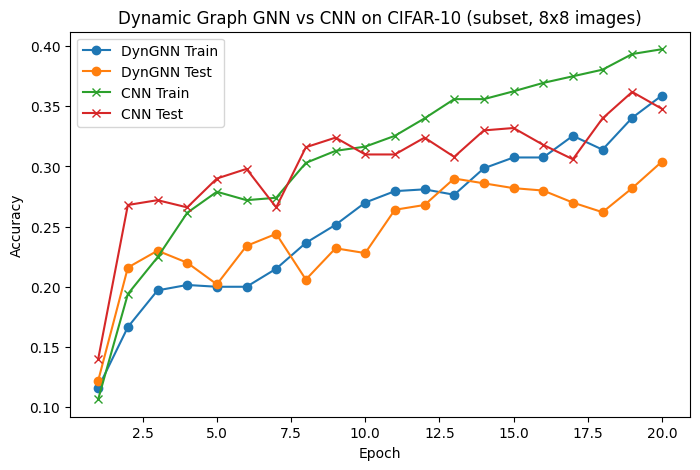

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision
import torchvision.transforms as T

import random
import numpy as np
import matplotlib.pyplot as plt

# ---- PyTorch Geometric ----
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import DynamicEdgeConv, global_mean_pool

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# ==================================================================
# 1. CIFAR-10を読み込み、(8,8) に縮小、さらに (4×4パッチ=16ノード) に分割
# ==================================================================

# データ変換: 32x32 -> 8x8 にリサイズ, Tensor化
transform = T.Compose([
    T.Resize((8,8)),  
    T.ToTensor()
])
cifar_train = torchvision.datasets.CIFAR10(root='.', train=True,  download=True, transform=transform)
cifar_test  = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform)

# 小規模サブセット (train=2000, test=500) で実験
train_indices = list(range(2000))
test_indices  = list(range(500))
random.shuffle(train_indices)

train_subset = Subset(cifar_train, train_indices)
test_subset  = Subset(cifar_test, test_indices)


# -------------------------
# パッチ分割設定
# -------------------------
C, H, W = 3, 8, 8   # 変換後 (3,8,8)
PATCH_SIZE = 4      # 4×4 パッチ
NUM_PATCH_H = H // PATCH_SIZE  # =2
NUM_PATCH_W = W // PATCH_SIZE  # =2
NUM_NODES = NUM_PATCH_H * NUM_PATCH_W   # =4
PATCH_DIM = PATCH_SIZE * PATCH_SIZE * C # 4×4×3=48

# ==========================
# 2. 可変グラフ用 Dataset
# ==========================
# DynamicEdgeConv では、初期グラフ(edge_index)は不要。
# ノード特徴 x と y(ラベル) を渡せばOK。

def image_to_node_features(img_tensor):
    """
    img_tensor: shape (3,8,8)
    4x4パッチに分割 → (4ノード, 48次元) の特徴ベクトル
    """
    patches = []
    for i in range(NUM_PATCH_H):
        for j in range(NUM_PATCH_W):
            patch = img_tensor[:, i*PATCH_SIZE:(i+1)*PATCH_SIZE, j*PATCH_SIZE:(j+1)*PATCH_SIZE]
            patch_flat = patch.reshape(-1)  # (48,)
            patches.append(patch_flat)
    patches = torch.stack(patches, dim=0)  # shape: (4,48)
    return patches  # ノード特徴

class CifarDynGraphDataset(Dataset):
    def __init__(self, subset):
        self.subset = subset
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        img, label = self.subset[idx]  # (3,8,8), int
        x = image_to_node_features(img)  # shape: (4,48)
        data = Data(x=x)  # edge_index不要 (DynamicEdgeConvが自動計算)
        data.y = torch.tensor([label], dtype=torch.long)
        return data

train_graph_dataset = CifarDynGraphDataset(train_subset)
test_graph_dataset  = CifarDynGraphDataset(test_subset)

train_graph_loader = GeoDataLoader(train_graph_dataset, batch_size=16, shuffle=True)
test_graph_loader  = GeoDataLoader(test_graph_dataset,  batch_size=16, shuffle=False)


# ==========================
# 3. DynamicEdgeConvモデル
# ==========================
# ノード数=4, 特徴次元=48。
# 各層でノード埋め込みが変化するたびに、k=2~3などのKNN再構築を行う。
# (ここではk=2に設定: ノード4つしかないので小さめ)
# ==========================

# EdgeConv(MLP)に渡す内訳: 入力次元 = 48*2 (2ノードの特徴を連結したもの)
# ただし PyGのDynamicEdgeConv は自動で (x_i || x_j) を作るので、MLPの in_channels=48*2=96 が必要。

class MLPConv(nn.Module):
    """EdgeConvで使う点対点演算のMLP"""
    def __init__(self, in_channels=96, out_channels=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_channels, 64),
            nn.ReLU(),
            nn.Linear(64, out_channels)  # out_channels=64
        )
    def forward(self, x):
        return self.net(x)

class DynamicGNN(nn.Module):
    def __init__(self, k=2, hidden_dim=64, fc_hidden=128, num_classes=10):
        super().__init__()
        
        # EdgeConvレイヤ1
        self.edgeconv1 = DynamicEdgeConv(
            nn=MLPConv(in_channels=48*2, out_channels=hidden_dim),
            k=k
        )
        # EdgeConvレイヤ2
        self.edgeconv2 = DynamicEdgeConv(
            nn=MLPConv(in_channels=hidden_dim*2, out_channels=hidden_dim),
            k=k
        )
        
        # 最後に global_mean_pool → 2層MLP
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, fc_hidden),
            nn.ReLU(),
            nn.Linear(fc_hidden, num_classes)
        )
    
    def forward(self, x, batch):
        """
        x: shape (total_nodes_in_batch, 48)
        batch: (total_nodes_in_batch,)
        """
        # 1層目:  EdgeConv
        x = self.edgeconv1(x, batch)  # -> (N, hidden_dim)
        x = F.relu(x)
        
        # 2層目: EdgeConv
        x = self.edgeconv2(x, batch)  # -> (N, hidden_dim)
        x = F.relu(x)
        
        # グローバルプーリング (各グラフのノードを平均)
        x = global_mean_pool(x, batch)  # (batch_size, hidden_dim)
        
        out = self.mlp(x)  # (batch_size, num_classes)
        return out

dyn_model = DynamicGNN(k=2).to(device)
dyn_optimizer = optim.Adam(dyn_model.parameters(), lr=1e-3)
dyn_criterion = nn.CrossEntropyLoss()


def train_dyn_epoch():
    dyn_model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    for data in train_graph_loader:
        data = data.to(device)
        dyn_optimizer.zero_grad()
        
        out = dyn_model(data.x, data.batch)
        loss = dyn_criterion(out, data.y)
        loss.backward()
        dyn_optimizer.step()
        
        preds = out.argmax(dim=1)
        correct = (preds == data.y).sum().item()
        
        total_loss += loss.item() * data.num_graphs
        total_correct += correct
        total_samples += data.num_graphs
    
    return total_loss / total_samples, total_correct / total_samples

@torch.no_grad()
def eval_dyn(loader):
    dyn_model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    for data in loader:
        data = data.to(device)
        out = dyn_model(data.x, data.batch)
        loss = dyn_criterion(out, data.y)
        preds = out.argmax(dim=1)
        correct = (preds == data.y).sum().item()
        
        total_loss += loss.item() * data.num_graphs
        total_correct += correct
        total_samples += data.num_graphs
    
    return total_loss / total_samples, total_correct / total_samples


# ==========================
# 4. CNN (同じFC構造)
# ==========================
class SimpleCNN(nn.Module):
    def __init__(self, fc_hidden=128, num_classes=10):
        super().__init__()
        # 入力 (3,8,8)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        
        # 最終的に (B,32,2,2) => 32*2*2=128
        self.mlp = nn.Sequential(
            nn.Linear(128, fc_hidden),
            nn.ReLU(),
            nn.Linear(fc_hidden, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)  # (B,16,8,8)
        x = F.relu(x)
        x = self.pool(x)   # -> (B,16,4,4)
        x = self.conv2(x)  # -> (B,32,4,4)
        x = F.relu(x)
        x = self.pool(x)   # -> (B,32,2,2)
        
        x = x.view(x.size(0), -1)  # (B,128)
        out = self.mlp(x)          # (B,10)
        return out

cnn_model = SimpleCNN().to(device)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)
cnn_criterion = nn.CrossEntropyLoss()

train_loader_cnn = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader_cnn  = DataLoader(test_subset,  batch_size=64, shuffle=False)

def train_cnn_epoch():
    cnn_model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    for imgs, labels in train_loader_cnn:
        imgs, labels = imgs.to(device), labels.to(device)
        cnn_optimizer.zero_grad()
        
        out = cnn_model(imgs)
        loss = cnn_criterion(out, labels)
        loss.backward()
        cnn_optimizer.step()
        
        preds = out.argmax(dim=1)
        correct = (preds == labels).sum().item()
        
        total_loss += loss.item() * imgs.size(0)
        total_correct += correct
        total_samples += imgs.size(0)
    
    return total_loss / total_samples, total_correct / total_samples

@torch.no_grad()
def eval_cnn(loader):
    cnn_model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = cnn_model(imgs)
        loss = cnn_criterion(out, labels)
        preds = out.argmax(dim=1)
        correct = (preds == labels).sum().item()
        
        total_loss += loss.item() * imgs.size(0)
        total_correct += correct
        total_samples += imgs.size(0)
    
    return total_loss / total_samples, total_correct / total_samples


# ==========================
# 5. 学習 & 比較
# ==========================
EPOCHS = 20
dyn_train_accs, dyn_test_accs = [], []
cnn_train_accs, cnn_test_accs = [], []

for epoch in range(1, EPOCHS+1):
    # --- Dynamic GNN ---
    d_train_loss, d_train_acc = train_dyn_epoch()
    d_test_loss,  d_test_acc  = eval_dyn(test_graph_loader)
    dyn_train_accs.append(d_train_acc)
    dyn_test_accs.append(d_test_acc)
    
    # --- CNN ---
    c_train_loss, c_train_acc = train_cnn_epoch()
    c_test_loss,  c_test_acc  = eval_cnn(test_loader_cnn)
    cnn_train_accs.append(c_train_acc)
    cnn_test_accs.append(c_test_acc)
    
    print(f"Epoch[{epoch}/{EPOCHS}]")
    print(f"  DynGNN train_acc={d_train_acc:.3f}, test_acc={d_test_acc:.3f}")
    print(f"  CNN    train_acc={c_train_acc:.3f}, test_acc={c_test_acc:.3f}")

# 可視化
plt.figure(figsize=(8,5))
plt.plot(range(1,EPOCHS+1), dyn_train_accs, label="DynGNN Train", marker='o')
plt.plot(range(1,EPOCHS+1), dyn_test_accs,  label="DynGNN Test",  marker='o')
plt.plot(range(1,EPOCHS+1), cnn_train_accs, label="CNN Train", marker='x')
plt.plot(range(1,EPOCHS+1), cnn_test_accs,  label="CNN Test",  marker='x')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Dynamic Graph GNN vs CNN on CIFAR-10 (subset, 8x8 images)")
plt.legend()
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch[1/10] train_acc=0.138, test_acc=0.210
Epoch[2/10] train_acc=0.186, test_acc=0.194
Epoch[3/10] train_acc=0.181, test_acc=0.208
Epoch[4/10] train_acc=0.175, test_acc=0.208
Epoch[5/10] train_acc=0.193, test_acc=0.186
Epoch[6/10] train_acc=0.191, test_acc=0.220
Epoch[7/10] train_acc=0.204, test_acc=0.186
Epoch[8/10] train_acc=0.210, test_acc=0.208
Epoch[9/10] train_acc=0.216, test_acc=0.234
Epoch[10/10] train_acc=0.206, test_acc=0.224


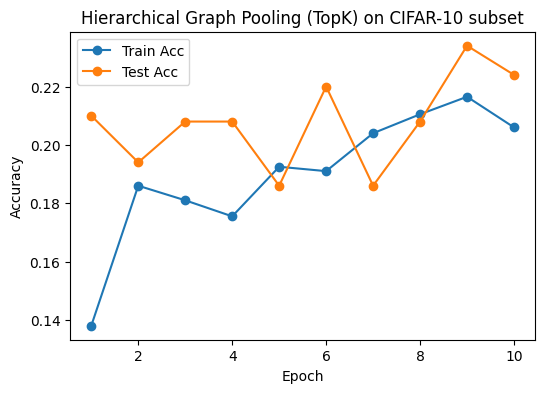

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision
import torchvision.transforms as T

import random
import numpy as np
import matplotlib.pyplot as plt

# ---- PyTorch Geometric ----
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# =====================================================
# 1. データセット
#  - CIFAR-10をダウンロードし、16x16に縮小。
#  - 4x4パッチに分割 → ノード数=16。
#  - エッジはパッチ間をK近傍 or 単純な格子状で結んでおく。
# =====================================================
transform = T.Compose([
    T.Resize((16,16)),  
    T.ToTensor()
])
cifar_train = torchvision.datasets.CIFAR10(root='.', train=True,  download=True, transform=transform)
cifar_test  = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform)

# 小規模サブセット
train_indices = list(range(2000))  # 2000枚
test_indices  = list(range(500))   # 500枚
random.shuffle(train_indices)

train_subset = Subset(cifar_train, train_indices)
test_subset  = Subset(cifar_test, test_indices)

# パッチ分割の設定
C, H, W = 3, 16, 16
PATCH_SIZE = 4  # 4x4
NUM_PATCH_H = H // PATCH_SIZE  # 4
NUM_PATCH_W = W // PATCH_SIZE  # 4
NUM_NODES = NUM_PATCH_H * NUM_PATCH_W  # 16
PATCH_DIM = PATCH_SIZE * PATCH_SIZE * C  # 4*4*3 = 48

def image_to_graph(img_tensor, k=4):
    """
    img_tensor: shape (3,16,16)
    1) 4x4パッチに分割 → 16ノード (各ノード48次元)
    2) K近傍でエッジ (あるいは格子状エッジ) を作成
    """
    # ---- パッチ化 ----
    patches = []
    for i in range(NUM_PATCH_H):  # 0..3
        for j in range(NUM_PATCH_W):  # 0..3
            patch = img_tensor[:, 
                               i*PATCH_SIZE:(i+1)*PATCH_SIZE,
                               j*PATCH_SIZE:(j+1)*PATCH_SIZE]
            patch_flat = patch.reshape(-1)  # (48,)
            patches.append(patch_flat)
    x = torch.stack(patches, dim=0)  # shape: (16,48)
    
    # ---- K近傍 で edge_index 作成 (特徴ベクトル空間で近傍) ----
    #   ※実装をシンプルにするため scikit-learn で KNN
    from sklearn.neighbors import NearestNeighbors
    import numpy as np
    x_np = x.numpy()
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(x_np)
    _, indices = nbrs.kneighbors(x_np)
    
    edge_list = []
    for i in range(NUM_NODES):
        neighbors = indices[i][1:]  # 0番目は自分
        for nbr in neighbors:
            edge_list.append([i, nbr])  # 有向にしてもいいが、無向にしたいなら両方向など
            edge_list.append([nbr, i])
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    data = Data(x=x, edge_index=edge_index)
    return data

class CifarHierarchyDataset(Dataset):
    def __init__(self, subset):
        self.subset = subset
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        img, label = self.subset[idx]  # (3,16,16)
        graph_data = image_to_graph(img, k=4)  # K=4近傍
        graph_data.y = torch.tensor([label], dtype=torch.long)
        return graph_data

train_graph_dataset = CifarHierarchyDataset(train_subset)
test_graph_dataset  = CifarHierarchyDataset(test_subset)

train_loader = GeoDataLoader(train_graph_dataset, batch_size=16, shuffle=True)
test_loader  = GeoDataLoader(test_graph_dataset,  batch_size=16, shuffle=False)


# =====================================================
# 2. 階層的プーリング (TopKPoolingを2段)
# =====================================================
class HierarchicalGNN(nn.Module):
    """
    2層GCNConv + 2回TopKPooling の階層構造。
    (16ノード)→(TopK ratio=0.5=>8ノード)→(GCN)→(TopK ratio=0.5=>4ノード)→global_mean_pool(4->1)
    """
    def __init__(self, in_dim=48, hidden_dim=64, ratio=0.5, fc_hidden=128, num_classes=10):
        super().__init__()
        # --- 1層目 ---
        self.gcn1 = GCNConv(in_dim, hidden_dim)
        self.pool1 = TopKPooling(hidden_dim, ratio=ratio)
        
        # --- 2層目 ---
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.pool2 = TopKPooling(hidden_dim, ratio=ratio)
        
        # --- 全結合部: 2層MLP ---
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, fc_hidden),
            nn.ReLU(),
            nn.Linear(fc_hidden, num_classes)
        )
    
    def forward(self, x, edge_index, batch):
        # -------------------
        # 1) GCNConv -> TopK
        # -------------------
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, batch=batch)
        
        # -------------------
        # 2) GCNConv -> TopK
        # -------------------
        x = self.gcn2(x, edge_index)
        x = F.relu(x)
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, batch=batch)
        
        # -------------------
        # 3) グローバルプーリング
        # -------------------
        x = global_mean_pool(x, batch)  # (batch_size, hidden_dim)
        
        # -------------------
        # 4) 全結合
        # -------------------
        out = self.mlp(x)  # (batch_size, num_classes)
        return out

model = HierarchicalGNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


# =====================================================
# 3. 学習ループ
# =====================================================
def train_one_epoch():
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        
        preds = out.argmax(dim=1)
        correct = (preds == data.y).sum().item()
        
        total_loss += loss.item() * data.num_graphs
        total_correct += correct
        total_samples += data.num_graphs
    
    return total_loss / total_samples, total_correct / total_samples

@torch.no_grad()
def eval_model(loader):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        
        preds = out.argmax(dim=1)
        correct = (preds == data.y).sum().item()
        
        total_loss += loss.item() * data.num_graphs
        total_correct += correct
        total_samples += data.num_graphs
    
    return total_loss / total_samples, total_correct / total_samples


# =====================================================
# 4. 学習 & 可視化
# =====================================================
EPOCHS = 10
train_accs, test_accs = [], []

for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train_one_epoch()
    test_loss, test_acc   = eval_model(test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f"Epoch[{epoch}/{EPOCHS}] train_acc={train_acc:.3f}, test_acc={test_acc:.3f}")


# 学習曲線の可視化
plt.figure(figsize=(6,4))
plt.plot(range(1,EPOCHS+1), train_accs, label="Train Acc", marker='o')
plt.plot(range(1,EPOCHS+1), test_accs,  label="Test Acc",  marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Hierarchical Graph Pooling (TopK) on CIFAR-10 subset")
plt.legend()
plt.show()
